# Pain Classification Pipeline - Multi-class LSTM

Clean pipeline for pain classification using LSTM on time series data.

## 1. Setup

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    roc_curve, auc, precision_recall_curve, average_precision_score
 )
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Create figures directory
Path('./figures').mkdir(exist_ok=True)

def to_categorical(y, num_classes):
    y = np.asarray(y, dtype=np.int64)
    return np.eye(num_classes, dtype=np.float32)[y]

print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")


PyTorch version: 2.9.0+cpu
NumPy version: 2.2.6
Pandas version: 2.3.3


## 2. Data Loading

In [82]:
# Load data files
train_df = pd.read_csv('pirate_pain_train.csv')
labels_df = pd.read_csv('pirate_pain_train_labels.csv')
test_df = pd.read_csv('pirate_pain_test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# Merge labels with train data
train_df = train_df.merge(labels_df, on='sample_index', how='left')

# Sort by time within each sequence
train_df = train_df.sort_values(['sample_index', 'time']).reset_index(drop=True)
test_df = test_df.sort_values(['sample_index', 'time']).reset_index(drop=True)

print("Data loaded successfully")
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Sample submission shape: {sample_submission.shape}")

Data loaded successfully
Train shape: (105760, 41)
Test shape: (211840, 40)
Sample submission shape: (1324, 2)


In [83]:
# Data statistics
print("\n=== Label Distribution ===")
label_col = [col for col in train_df.columns if col not in test_df.columns and col != 'sample_index'][0]
train_label_series = train_df.groupby('sample_index')[label_col].first()
print(f"Label column: {label_col}")
print(train_label_series.value_counts().sort_index())

# Fixed label mapping: ensure deterministic encoding
label_to_id = {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}
expected_labels = set(label_to_id.keys())
observed_labels = set(train_label_series.unique())
if observed_labels != expected_labels:
    missing = expected_labels - observed_labels
    unexpected = observed_labels - expected_labels
    raise ValueError(f"Label mismatch. Missing: {missing}, Unexpected: {unexpected}")

id_to_label = {idx: label for label, idx in label_to_id.items()}
label_mapping_path = Path('label_mapping.json')
with open(label_mapping_path, 'w') as f:
    json.dump({'label_to_id': label_to_id, 'id_to_label': id_to_label}, f, indent=2)
print(f"\nLabel mapping saved to {label_mapping_path.resolve()}")

# Encode labels
train_df[label_col] = train_df[label_col].map(label_to_id)
if train_df[label_col].isna().any():
    raise ValueError("Label encoding produced NaNs; check mapping.")

print(f"\nLabel to index mapping: {label_to_id}")

num_classes = len(label_to_id)
print(f"\nNumber of classes: {num_classes}")

# Sequence length statistics
train_seq_lengths = train_df.groupby('sample_index').size()
test_seq_lengths = test_df.groupby('sample_index').size()

print("\n=== Training Sequence Lengths ===")
print(f"Min: {train_seq_lengths.min()}")
print(f"Median: {train_seq_lengths.median():.0f}")
print(f"Max: {train_seq_lengths.max()}")
print(f"Total sequences: {len(train_seq_lengths)}")

print("\n=== Test Sequence Lengths ===")
print(f"Min: {test_seq_lengths.min()}")
print(f"Median: {test_seq_lengths.median():.0f}")
print(f"Max: {test_seq_lengths.max()}")
print(f"Total sequences: {len(test_seq_lengths)}")


=== Label Distribution ===
Label column: label
label
high_pain     56
low_pain      94
no_pain      511
Name: count, dtype: int64

Label mapping saved to C:\Users\filip\Documents\GitHub\challenge_an2dl\label_mapping.json

Label to index mapping: {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}

Number of classes: 3

=== Training Sequence Lengths ===
Min: 160
Median: 160
Max: 160
Total sequences: 661

=== Test Sequence Lengths ===
Min: 160
Median: 160
Max: 160
Total sequences: 1324


In [84]:
# Stratified train/validation split at sequence level
sample_labels = train_df.groupby('sample_index')[label_col].first()
train_indices, val_indices = train_test_split(
    sample_labels.index,
    test_size=0.2,
    random_state=SEED,
    stratify=sample_labels
 )
train_indices = np.array(sorted(train_indices))
val_indices = np.array(sorted(val_indices))

print("\n=== Train/Validation Split ===")
print(f"Train sequences: {len(train_indices)}")
print(f"Validation sequences: {len(val_indices)}")
print(f"Class distribution (train):\n{sample_labels.loc[train_indices].value_counts().sort_index()}")
print(f"Class distribution (val):\n{sample_labels.loc[val_indices].value_counts().sort_index()}")


=== Train/Validation Split ===
Train sequences: 528
Validation sequences: 133
Class distribution (train):
label
0    408
1     75
2     45
Name: count, dtype: int64
Class distribution (val):
label
0    103
1     19
2     11
Name: count, dtype: int64
Class distribution (train):
label
0    408
1     75
2     45
Name: count, dtype: int64
Class distribution (val):
label
0    103
1     19
2     11
Name: count, dtype: int64


## 3. Feature Groups Definition

In [85]:
# Identify feature columns
exclude_cols = {'sample_index', 'time', label_col}
all_feature_cols = [col for col in train_df.columns if col not in exclude_cols]

# JOINT features: joint_00 to joint_30 (continuous, time-varying)
joint_cols = [col for col in all_feature_cols if col.startswith('joint_')]

# SURVEY features: pain_survey_1 to pain_survey_4 (ordinal 0/1/2)
survey_cols = [col for col in all_feature_cols if col.startswith('pain_survey_')]

# BODY features: static subject features
body_cols = [col for col in all_feature_cols if col not in joint_cols + survey_cols]

# Separate body into categorical and continuous
body_cat_cols = [col for col in body_cols if train_df[col].dtype == 'object']
body_cont_cols = [col for col in body_cols if col not in body_cat_cols]

print("=== Feature Groups ===")
print(f"JOINT features ({len(joint_cols)}): {joint_cols[:3] if len(joint_cols) >= 3 else joint_cols}...{joint_cols[-3:] if len(joint_cols) >= 3 else []}")
print(f"SURVEY features ({len(survey_cols)}): {survey_cols}")
print(f"BODY categorical ({len(body_cat_cols)}): {body_cat_cols}")
print(f"BODY continuous ({len(body_cont_cols)}): {body_cont_cols}")
print(f"\nTotal features: {len(all_feature_cols)}")

=== Feature Groups ===
JOINT features (31): ['joint_00', 'joint_01', 'joint_02']...['joint_28', 'joint_29', 'joint_30']
SURVEY features (4): ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
BODY categorical (3): ['n_legs', 'n_hands', 'n_eyes']
BODY continuous (0): []

Total features: 38


## 4. Preprocessing

In [86]:
def preprocess_data(df, is_train=True, scaler_joint=None, scaler_survey=None, body_cat_medians=None):
    """
    Preprocess data:
    - Interpolate NaN in JOINT features only
    - Map categorical BODY features to numeric
    - Fill missing BODY categorical with median
    - Scale JOINT and BODY continuous features
    - Optionally scale SURVEY features with MinMax to [0,1]
    """
    df = df.copy()
    
    # 1. Interpolate JOINT features (only NaN, not zeros)
    for col in joint_cols:
        if col in df.columns:
            df[col] = df.groupby('sample_index')[col].transform(
                lambda x: x.interpolate(method='linear', limit_direction='both')
            )
    
    # 2. Map categorical BODY features to numeric
    body_cat_mapping = {
        'zero': 0, 'one': 1, 'two': 2, 'three': 3
    }
    
    for col in body_cat_cols:
        if col in df.columns:
            df[col] = df[col].map(body_cat_mapping)
    
    # 3. Fill missing BODY categorical with median (training set)
    if is_train:
        body_cat_medians = {}
        for col in body_cat_cols:
            if col in df.columns:
                median_val = df.groupby('sample_index')[col].first().median()
                body_cat_medians[col] = median_val
                df[col] = df.groupby('sample_index')[col].transform(
                    lambda x: x.fillna(median_val)
                )
    else:
        for col in body_cat_cols:
            if col in df.columns and col in body_cat_medians:
                df[col] = df.groupby('sample_index')[col].transform(
                    lambda x: x.fillna(body_cat_medians[col])
                )
    
    # 4. Replicate BODY features across all timesteps (they are static per sequence)
    for col in body_cols:
        if col in df.columns:
            df[col] = df.groupby('sample_index')[col].transform('first')
    
    # 5. Scaling
    scale_cols_joint_body = joint_cols + body_cont_cols
    
    if is_train:
        if scale_cols_joint_body:
            scaler_joint = StandardScaler()
            df[scale_cols_joint_body] = scaler_joint.fit_transform(df[scale_cols_joint_body])
        
        if survey_cols:
            scaler_survey = MinMaxScaler(feature_range=(0, 1))
            df[survey_cols] = scaler_survey.fit_transform(df[survey_cols])
    else:
        if scale_cols_joint_body and scaler_joint is not None:
            df[scale_cols_joint_body] = scaler_joint.transform(df[scale_cols_joint_body])
        
        if survey_cols and scaler_survey is not None:
            df[survey_cols] = scaler_survey.transform(df[survey_cols])
    
    return df, scaler_joint, scaler_survey, body_cat_medians

# Split processed dataframe into train/validation subsets
train_df_train = train_df[train_df['sample_index'].isin(train_indices)].copy()
train_df_val = train_df[train_df['sample_index'].isin(val_indices)].copy()

# Preprocess datasets using training fit for scalers/medians
train_df_train, scaler_joint, scaler_survey, body_cat_medians = preprocess_data(
    train_df_train, is_train=True
 )

train_df_val, _, _, _ = preprocess_data(
    train_df_val, is_train=False,
    scaler_joint=scaler_joint,
    scaler_survey=scaler_survey,
    body_cat_medians=body_cat_medians
 )

test_df_processed, _, _, _ = preprocess_data(
    test_df, is_train=False,
    scaler_joint=scaler_joint,
    scaler_survey=scaler_survey,
    body_cat_medians=body_cat_medians
 )
test_df = test_df_processed

print("Preprocessing completed")
print(f"Training data shape: {train_df_train.shape}")
print(f"Validation data shape: {train_df_val.shape}")
print(f"Test data shape: {test_df.shape}")

Preprocessing completed
Training data shape: (84480, 41)
Validation data shape: (21280, 41)
Test data shape: (211840, 40)


In [87]:
train_df_train.head()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30,label
0,0,0,1.0,0.0,1.0,0.5,2.0,2.0,2.0,0.744965,...,-0.007520,-0.022874,-0.039364,-0.029233,-0.401007,-0.555541,-0.374708,-0.480330,0.0,0
1,0,1,1.0,1.0,1.0,1.0,2.0,2.0,2.0,0.945679,...,-0.007727,-0.021404,-0.070840,-0.030302,-0.470289,-0.721823,-0.605195,-0.678392,0.0,0
2,0,2,1.0,0.0,1.0,1.0,2.0,2.0,2.0,0.675740,...,-0.007810,-0.024732,-0.064324,-0.029596,-0.423339,-0.621984,-0.421089,-0.546492,0.0,0
3,0,3,1.0,1.0,1.0,1.0,2.0,2.0,2.0,-0.031994,...,-0.007748,-0.024440,-0.070818,-0.030302,-0.495138,-0.630113,-0.343530,-0.524813,0.0,0
4,0,4,1.0,1.0,1.0,1.0,2.0,2.0,2.0,0.722550,...,-0.007809,-0.024655,-0.070808,-0.028324,-0.600881,-0.690660,-0.267742,-0.515263,0.0,0


## 5. Sequence Length Uniformization

In [88]:
def create_sequences(df, label_col=None, T_target=None):
    """
    Convert dataframe to sequences of uniform length.
    - If sequence is shorter than T_target: edge padding (repeat last frame)
    - If sequence is longer than T_target: truncate from the end
    """
    feature_cols = joint_cols + survey_cols + body_cols
    
    # Calculate T_target from training data if not provided
    if T_target is None:
        seq_lengths = df.groupby('sample_index').size()
        T_target = int(seq_lengths.max())
        print(f"T_target automatically set to: {T_target}")
    
    X_list = []
    y_list = []
    sample_indices = []
    
    for sample_idx in df['sample_index'].unique():
        seq_df = df[df['sample_index'] == sample_idx].sort_values('time')
        
        # Extract features
        seq_features = seq_df[feature_cols].values
        seq_len = len(seq_features)
        
        # Pad or truncate to T_target
        if seq_len < T_target:
            padding = np.repeat(seq_features[-1:], T_target - seq_len, axis=0)
            seq_features = np.vstack([seq_features, padding])
        elif seq_len > T_target:
            seq_features = seq_features[:T_target]
        
        X_list.append(seq_features)
        sample_indices.append(sample_idx)
        
        if label_col is not None:
            y_list.append(seq_df[label_col].iloc[0])
    
    X = np.array(X_list)
    
    expected_shape = (len(X), T_target, len(feature_cols))
    assert X.shape == expected_shape, f"Shape mismatch: {X.shape} != {expected_shape}"
    print(f"Sequences created: {X.shape}")
    
    if label_col is not None:
        y = np.array(y_list)
        return X, y, T_target, sample_indices
    else:
        return X, None, T_target, sample_indices

# Create sequences for each split
X_train, y_train, T_target, train_sample_indices = create_sequences(
    train_df_train, label_col=label_col, T_target=None
 )

X_val, y_val, _, val_sample_indices = create_sequences(
    train_df_val, label_col=label_col, T_target=T_target
 )

X_test, _, _, test_sample_indices = create_sequences(
    test_df, label_col=None, T_target=T_target
 )

print(f"\n=== Sequence Shapes ===")
print(f"T_target: {T_target}")
print(f"Training sequences: {X_train.shape}")
print(f"Validation sequences: {X_val.shape}")
print(f"Test sequences: {X_test.shape}")
print(f"Number of features: {X_train.shape[2]}")

# Compute class weights to address class imbalance
# check etichette
assert y_train.dtype in (np.int32, np.int64), "y_train deve essere intera (0..K-1)"

# pesi bilanciati
cw = compute_class_weight(class_weight='balanced',
                          classes=np.arange(num_classes),
                          y=y_train)

# opzionale: piccolo boost alla classe più debole (es. classe 2)
cw_tuned = cw.copy()
cw_tuned[2] *= 0.3   # +20% se serve più recall
cw_tuned[1] *= 0.4  # +10% se serve anche sulla classe 1

# cast a float “puro”
class_weights = {int(i): float(w) for i, w in enumerate(cw_tuned)}
print("Class weights:", class_weights)


T_target automatically set to: 160
Sequences created: (528, 160, 38)
Sequences created: (528, 160, 38)
Sequences created: (133, 160, 38)
Sequences created: (133, 160, 38)
Sequences created: (1324, 160, 38)

=== Sequence Shapes ===
T_target: 160
Training sequences: (528, 160, 38)
Validation sequences: (133, 160, 38)
Test sequences: (1324, 160, 38)
Number of features: 38
Class weights: {0: 0.43137254901960786, 1: 0.9386666666666668, 2: 1.1733333333333333}
Sequences created: (1324, 160, 38)

=== Sequence Shapes ===
T_target: 160
Training sequences: (528, 160, 38)
Validation sequences: (133, 160, 38)
Test sequences: (1324, 160, 38)
Number of features: 38
Class weights: {0: 0.43137254901960786, 1: 0.9386666666666668, 2: 1.1733333333333333}


In [89]:
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (528, 160, 38), (528,)
Validation set: (133, 160, 38), (133,)
Test set: (1324, 160, 38)


## 6. Model Architecture

In [91]:

# === opzionale: dropout spaziale sui canali ===
class SpatialDropout1D(nn.Module):
    def __init__(self, p: float):
        super().__init__()
        self.p = float(p)
    def forward(self, inputs):
        if self.p <= 0.0 or not self.training:
            return inputs
        x = inputs.unsqueeze(2)              # (B,T,1,F)
        x = F.dropout2d(x, p=self.p, training=self.training)
        return x.squeeze(2)                  # (B,T,F)

# === Classificatore SOLO LSTM (1-3 layer), nessuna attention/FC head ===
class LSTMClassifier(nn.Module):
    def __init__(
        self,
        input_dim: int,
        num_classes: int,
        hidden_size: int = 64,
        num_layers: int = 1,
        dropout: float = 0.0,
        spatial_do: float = 0.0,
        bidirectional: bool = False,   # tienilo False se vuoi “solo LSTM”
    ):
        super().__init__()
        self.spatial_dropout = SpatialDropout1D(spatial_do) if spatial_do > 0 else None
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=(dropout if num_layers > 1 else 0.0),
            bidirectional=bidirectional,
        )
        out_dim = hidden_size * (2 if bidirectional else 1)
        self.classifier = nn.Linear(out_dim, num_classes)  # unico strato di uscita

    def forward(self, inputs):
        x = inputs                                    # (B,T,F)
        if self.spatial_dropout is not None:
            x = self.spatial_dropout(x)
        out, (h_n, c_n) = self.lstm(x)                # h_n: (L*(D), B, H)
        feat = h_n[-1]                                # ultimo layer (B,H)  (se bi: puoi torch.cat di [-2,-1])
        logits = self.classifier(feat)                # (B,C)
        return logits

# === Early stopping su F1 macro (immutato) ===
class MacroF1EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0, restore_best_weights=True, verbose=0):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.verbose = verbose
        self.wait = 0
        self.best_macro_f1 = -np.inf
        self.best_state = None
    def step(self, macro_f1, model):
        if macro_f1 > self.best_macro_f1 + self.min_delta:
            self.best_macro_f1 = macro_f1
            self.wait = 0
            if self.restore_best_weights:
                self.best_state = copy.deepcopy(model.state_dict())
        else:
            self.wait += 1
        stop = self.wait > self.patience
        if stop and self.verbose:
            print(f"Early stopping triggered. Best macro-F1: {self.best_macro_f1:.4f}")
        return stop
    def restore(self, model):
        if self.restore_best_weights and self.best_state is not None:
            model.load_state_dict(self.best_state)

# === Wrapper aggiornato: solo LSTM, scegli 1/2/3 layer ===
class TorchPainModelWrapper:
    def __init__(
        self,
        input_shape,
        num_classes,
        hidden_size=64,
        num_layers=1,              # <—— scegli 1, 2 o 3
        lr=6e-4,
        weight_decay=2e-4,
        dropout=0.0,              # usato come dropout tra layer LSTM (>1 layer)
        spatial_do=0.0,
        label_smoothing=0.0,
        bidirectional=False,      # lascia False per “solo LSTM”
    ):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.num_classes = num_classes
        self.lr = lr
        self.weight_decay = weight_decay
        self.label_smoothing = label_smoothing
        self.clip_norm = 1.0

        input_dim = input_shape[-1]
        self.model = LSTMClassifier(
            input_dim=input_dim,
            num_classes=num_classes,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            spatial_do=spatial_do,
            bidirectional=bidirectional,
        ).to(self.device)

        self.best_val_macro_f1 = -np.inf
        self.history = None

    def fit(
        self,
        X_train, y_train,
        validation_data=None,
        epochs=100,
        batch_size=256,
        callbacks=None,
        class_weight=None,
        verbose=0,
    ):
        if validation_data is None:
            raise ValueError('validation_data must be provided for training.')
        X_val, y_val = validation_data

        train_dataset = TensorDataset(
            torch.tensor(X_train, dtype=torch.float32),
            torch.tensor(y_train, dtype=torch.long),
        )
        val_dataset = TensorDataset(
            torch.tensor(X_val, dtype=torch.float32),
            torch.tensor(y_val, dtype=torch.long),
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        class_weights_tensor = None
        if class_weight is not None:
            weights = [class_weight[int(i)] for i in range(self.num_classes)]
            class_weights_tensor = torch.tensor(weights, dtype=torch.float32, device=self.device)

        # usa la tua funzione già definita nel notebook
        criterion = make_cross_entropy(weight=class_weights_tensor, label_smoothing=self.label_smoothing).to(self.device)

        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=4, min_lr=1e-5
        )
        early_stopper = MacroF1EarlyStopping(patience=10, min_delta=1e-4, restore_best_weights=True, verbose=verbose)

        history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': [], 'val_macro_f1': []}

        for epoch in range(epochs):
            self.model.train()
            epoch_loss, correct, total = 0.0, 0, 0
            for batch_x, batch_y in train_loader:
                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)

                optimizer.zero_grad()
                logits = self.model(batch_x)
                loss = criterion(logits, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_norm)
                optimizer.step()

                epoch_loss += loss.item() * batch_x.size(0)
                preds = logits.argmax(dim=1)
                correct += (preds == batch_y).sum().item()
                total += batch_x.size(0)

            train_loss = epoch_loss / max(total, 1)
            train_acc = correct / max(total, 1)

            val_loss, val_acc, val_macro_f1, _ = self._evaluate(val_loader, criterion)
            scheduler.step(val_macro_f1)

            history['loss'].append(train_loss)
            history['accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)
            history['val_macro_f1'].append(val_macro_f1)

            if verbose:
                print(f"Epoch {epoch+1:03d}: loss={train_loss:.4f} acc={train_acc:.4f} "
                      f"val_loss={val_loss:.4f} val_acc={val_acc:.4f} val_f1={val_macro_f1:.4f}")

            if early_stopper.step(val_macro_f1, self.model):
                break

        early_stopper.restore(self.model)
        self.best_val_macro_f1 = early_stopper.best_macro_f1
        self.history = history
        return SimpleNamespace(history=history)

    def _evaluate(self, loader, criterion):
        self.model.eval()
        total_loss, total = 0.0, 0
        all_probs, all_labels = [], []
        with torch.no_grad():
            for batch_x, batch_y in loader:
                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)
                logits = self.model(batch_x)
                loss = criterion(logits, batch_y)
                probs = torch.softmax(logits, dim=1)
                total_loss += loss.item() * batch_x.size(0)
                total += batch_x.size(0)
                all_probs.append(probs.cpu().numpy())
                all_labels.append(batch_y.cpu().numpy())
        mean_loss = total_loss / max(total, 1)
        probs = np.concatenate(all_probs, axis=0)
        labels = np.concatenate(all_labels, axis=0)
        preds = probs.argmax(axis=1)
        accuracy = (preds == labels).mean()
        macro_f1 = f1_score(labels, preds, average='macro')
        return mean_loss, accuracy, macro_f1, probs

    def predict(self, X, verbose=0, batch_size=256):
        dataset = torch.tensor(X, dtype=torch.float32)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        self.model.eval()
        all_probs = []
        with torch.no_grad():
            for batch_x in loader:
                batch_x = batch_x.to(self.device)
                logits = self.model(batch_x)
                probs = torch.softmax(logits, dim=1)
                all_probs.append(probs.cpu().numpy())
        return np.concatenate(all_probs, axis=0)

# factory aggiornata
def build_model(
    input_shape,
    num_classes,
    hidden_size=64,
    num_layers=1,        # <—— imposta 1, 2 o 3
    lr=6e-4,
    weight_decay=2e-4,
    dropout=0.0,         # usato tra layer LSTM se num_layers>1
    spatial_do=0.0,
    label_smoothing=0.0,
    bidirectional=False, # lascia False per “solo LSTM”
):
    return TorchPainModelWrapper(
        input_shape=input_shape,
        num_classes=num_classes,
        hidden_size=hidden_size,
        num_layers=num_layers,
        lr=lr,
        weight_decay=weight_decay,
        dropout=dropout,
        spatial_do=spatial_do,
        label_smoothing=label_smoothing,
        bidirectional=bidirectional,
    )


## Grid

In [92]:
grid_configs = [
    # 1) LSTM leggero (1 layer)
{'hidden_size': 128, 'num_layers': 1, 'lr': 7e-4},

# 2) LSTM medio (2 layer)
{'hidden_size': 128, 'num_layers': 2, 'dropout': 0.2, 'lr': 7e-4},

# 3) LSTM profondo (3 layer)
{'hidden_size': 64, 'num_layers': 3, 'dropout': 0.1, 'lr': 5e-4},
]

In [93]:
# -- Risultati (LSTM-only) --
best_f1_macro = 0.0
best_config = None
best_model = None
grid_results = []

for idx, config in enumerate(grid_configs):
    print(f"\n{'='*60}")
    print(f"Testing config {idx+1}/{len(grid_configs)}: {config}")
    print('='*60)

    torch.cuda.empty_cache()
    torch.manual_seed(SEED)
    np.random.seed(SEED)

    # ATTENZIONE: grid_configs deve avere chiavi: 
    # 'hidden_size', 'num_layers', e (opzionali) 'lr','weight_decay','dropout','spatial_do','label_smoothing','bidirectional'
    model = build_model(
        input_shape=(T_target, X_train.shape[2]),
        num_classes=num_classes,
        hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        lr=config.get('lr', 6e-4),
        weight_decay=config.get('weight_decay', 2e-4),
        dropout=config.get('dropout', 0.0),        # usato solo se num_layers>1
        spatial_do=config.get('spatial_do', 0.0),
        label_smoothing=config.get('label_smoothing', 0.0),
        bidirectional=config.get('bidirectional', False),
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100, batch_size=256,
        #class_weight=class_weights,
        verbose=0
    )

    y_val_proba = model.predict(X_val, batch_size=256)
    y_val_pred = y_val_proba.argmax(axis=1)

    f1_macro = f1_score(y_val, y_val_pred, average='macro')
    f1_per_class = f1_score(y_val, y_val_pred, average=None)
    accuracy = (y_val_pred == y_val).mean()

    result = {
        'config': config,
        'f1_macro': float(f1_macro),
        'f1_per_class': [float(f) for f in f1_per_class],
        'accuracy': float(accuracy),
        'epochs_trained': len(history.history['loss']),
        'best_val_macro_f1': float(model.best_val_macro_f1),
    }
    grid_results.append(result)

    print(f"F1 Macro: {f1_macro:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 per class: {[f'{f:.4f}' for f in f1_per_class]}")
    print(f"Epochs trained: {result['epochs_trained']}")
    print(f"Best val macro-F1 observed: {model.best_val_macro_f1:.4f}")

    if f1_macro > best_f1_macro:
        best_f1_macro = f1_macro
        best_config = config
        best_model = model
        print("*** New best model! ***")

print(f"\n{'='*60}")
print("Grid search completed")
print(f"Best config: {best_config}")
print(f"Best F1 Macro: {best_f1_macro:.4f}")

with open('best_config.json', 'w') as f:
    json.dump({'config': best_config, 'f1_macro': float(best_f1_macro), 'T_target': int(T_target)}, f, indent=2)
print("\nBest config saved to best_config.json")



Testing config 1/3: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.0007}
F1 Macro: 0.3710
Accuracy: 0.7820
F1 per class: ['0.8821', '0.2308', '0.0000']
Epochs trained: 12
Best val macro-F1 observed: 0.3710
*** New best model! ***

Testing config 2/3: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.2, 'lr': 0.0007}
F1 Macro: 0.3710
Accuracy: 0.7820
F1 per class: ['0.8821', '0.2308', '0.0000']
Epochs trained: 12
Best val macro-F1 observed: 0.3710
*** New best model! ***

Testing config 2/3: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.2, 'lr': 0.0007}
F1 Macro: 0.7434
Accuracy: 0.8947
F1 per class: ['0.9524', '0.7778', '0.5000']
Epochs trained: 52
Best val macro-F1 observed: 0.7434
*** New best model! ***

Testing config 3/3: {'hidden_size': 64, 'num_layers': 3, 'dropout': 0.1, 'lr': 0.0005}
F1 Macro: 0.7434
Accuracy: 0.8947
F1 per class: ['0.9524', '0.7778', '0.5000']
Epochs trained: 52
Best val macro-F1 observed: 0.7434
*** New best model! ***

Testing config 3/3: {'hidden_siz

## 8. Final Training with Best Model

In [94]:
# The best model is already trained from grid search
# Get predictions for evaluation
y_val_pred = best_model.predict(X_val, verbose=0).argmax(axis=1)
y_val_proba = best_model.predict(X_val, verbose=0)

print("Best model ready for evaluation")
print(f"Validation accuracy: {(y_val_pred == y_val).mean():.4f}")
print(f"Validation F1 macro: {f1_score(y_val, y_val_pred, average='macro'):.4f}")

Best model ready for evaluation
Validation accuracy: 0.8947
Validation F1 macro: 0.7434


## 9. Evaluation and Visualization

In [95]:
# Retrain best model to get clean history for plots
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

best_config_kwargs = best_config.copy()
if 'wd' in best_config_kwargs:
    best_config_kwargs['weight_decay'] = best_config_kwargs.pop('wd')

torch.cuda.empty_cache()
final_model = build_model(
    input_shape=(T_target, X_train.shape[2]),
    num_classes=num_classes,
    **best_config_kwargs
 )

history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    #class_weight=class_weights,
    verbose=1
 )

best_model = final_model
print(f"Best validation macro-F1 (retrain): {final_model.best_val_macro_f1:.4f}")


Epoch 001: loss=1.0508 acc=0.7727 val_loss=0.9785 val_acc=0.7744 val_f1=0.2910
Epoch 002: loss=0.9631 acc=0.7727 val_loss=0.8783 val_acc=0.7744 val_f1=0.2910
Epoch 002: loss=0.9631 acc=0.7727 val_loss=0.8783 val_acc=0.7744 val_f1=0.2910
Epoch 003: loss=0.8566 acc=0.7727 val_loss=0.7373 val_acc=0.7744 val_f1=0.2910
Epoch 003: loss=0.8566 acc=0.7727 val_loss=0.7373 val_acc=0.7744 val_f1=0.2910
Epoch 004: loss=0.7211 acc=0.7746 val_loss=0.6436 val_acc=0.7744 val_f1=0.2910
Epoch 004: loss=0.7211 acc=0.7746 val_loss=0.6436 val_acc=0.7744 val_f1=0.2910
Epoch 005: loss=0.6584 acc=0.7746 val_loss=0.6611 val_acc=0.7744 val_f1=0.2922
Epoch 005: loss=0.6584 acc=0.7746 val_loss=0.6611 val_acc=0.7744 val_f1=0.2922
Epoch 006: loss=0.6644 acc=0.7746 val_loss=0.6374 val_acc=0.7820 val_f1=0.3255
Epoch 006: loss=0.6644 acc=0.7746 val_loss=0.6374 val_acc=0.7820 val_f1=0.3255
Epoch 007: loss=0.6367 acc=0.7784 val_loss=0.6271 val_acc=0.7744 val_f1=0.2922
Epoch 007: loss=0.6367 acc=0.7784 val_loss=0.6271 va

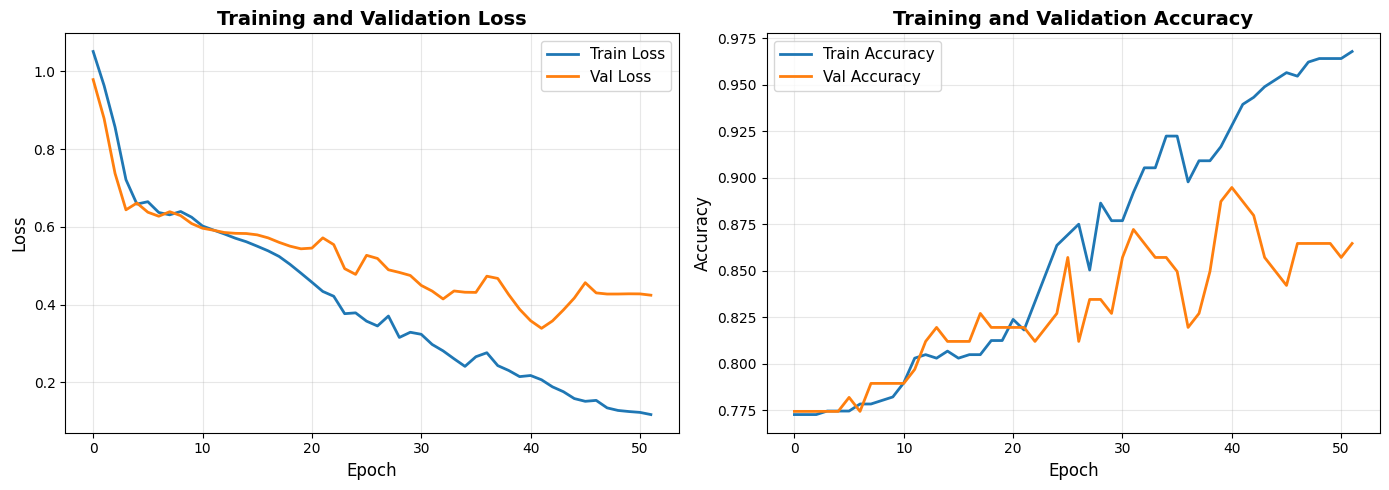

Training curves saved to ./figures/training_curves.png


In [96]:
# Training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./figures/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("Training curves saved to ./figures/training_curves.png")

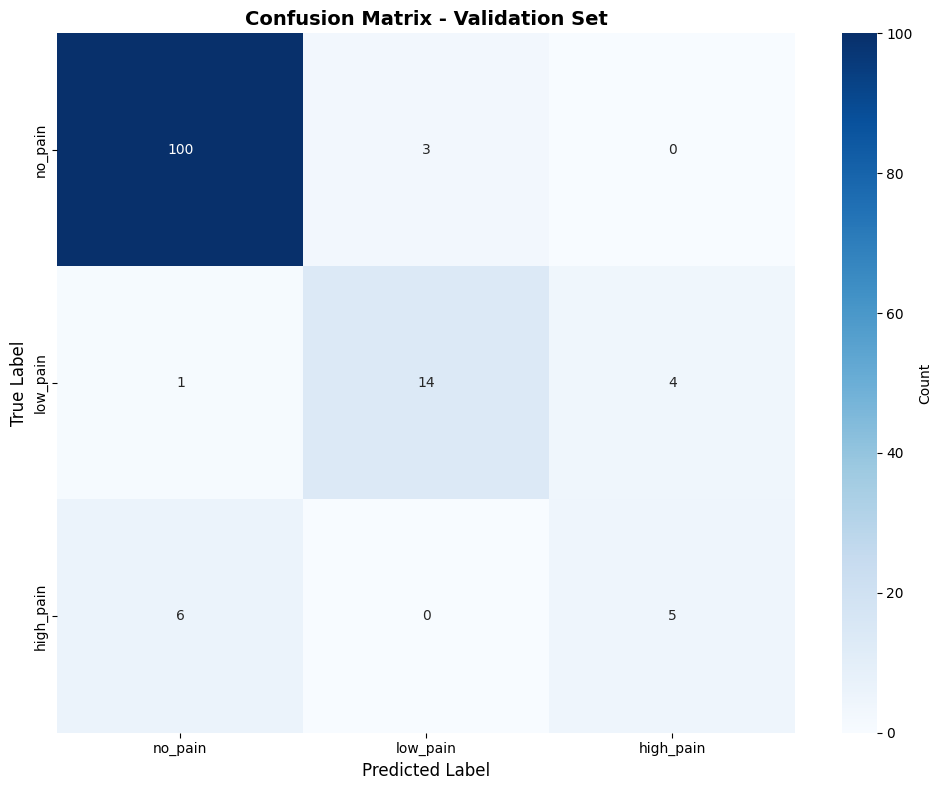

Confusion matrix saved to ./figures/confusion_matrix.png


In [97]:
# Confusion Matrix
y_val_pred = best_model.predict(X_val, verbose=0).argmax(axis=1)
cm = confusion_matrix(y_val, y_val_pred, labels=range(num_classes))
label_names = [id_to_label[i] for i in range(num_classes)]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, 
            yticklabels=label_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - Validation Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('./figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("Confusion matrix saved to ./figures/confusion_matrix.png")

In [98]:
# Classification Report
print("\n=== Label Mapping (index -> label) ===")
for idx in range(num_classes):
    print(f"  {idx}: {id_to_label[idx]}")

print("\n=== Classification Report ===")
target_names = [id_to_label[i] for i in range(num_classes)]
report = classification_report(y_val, y_val_pred, target_names=target_names, digits=4)
print(report)

# Calculate and display per-class F1 and macro F1
f1_per_class = f1_score(y_val, y_val_pred, average=None)
f1_macro = f1_score(y_val, y_val_pred, average='macro')

print("\n=== F1 Scores ===")
for idx, f1 in enumerate(f1_per_class):
    print(f"  {id_to_label[idx]}: {f1:.4f}")
print(f"\nMacro F1: {f1_macro:.4f}")


=== Label Mapping (index -> label) ===
  0: no_pain
  1: low_pain
  2: high_pain

=== Classification Report ===
              precision    recall  f1-score   support

     no_pain     0.9346    0.9709    0.9524       103
    low_pain     0.8235    0.7368    0.7778        19
   high_pain     0.5556    0.4545    0.5000        11

    accuracy                         0.8947       133
   macro avg     0.7712    0.7208    0.7434       133
weighted avg     0.8874    0.8947    0.8900       133


=== F1 Scores ===
  no_pain: 0.9524
  low_pain: 0.7778
  high_pain: 0.5000

Macro F1: 0.7434


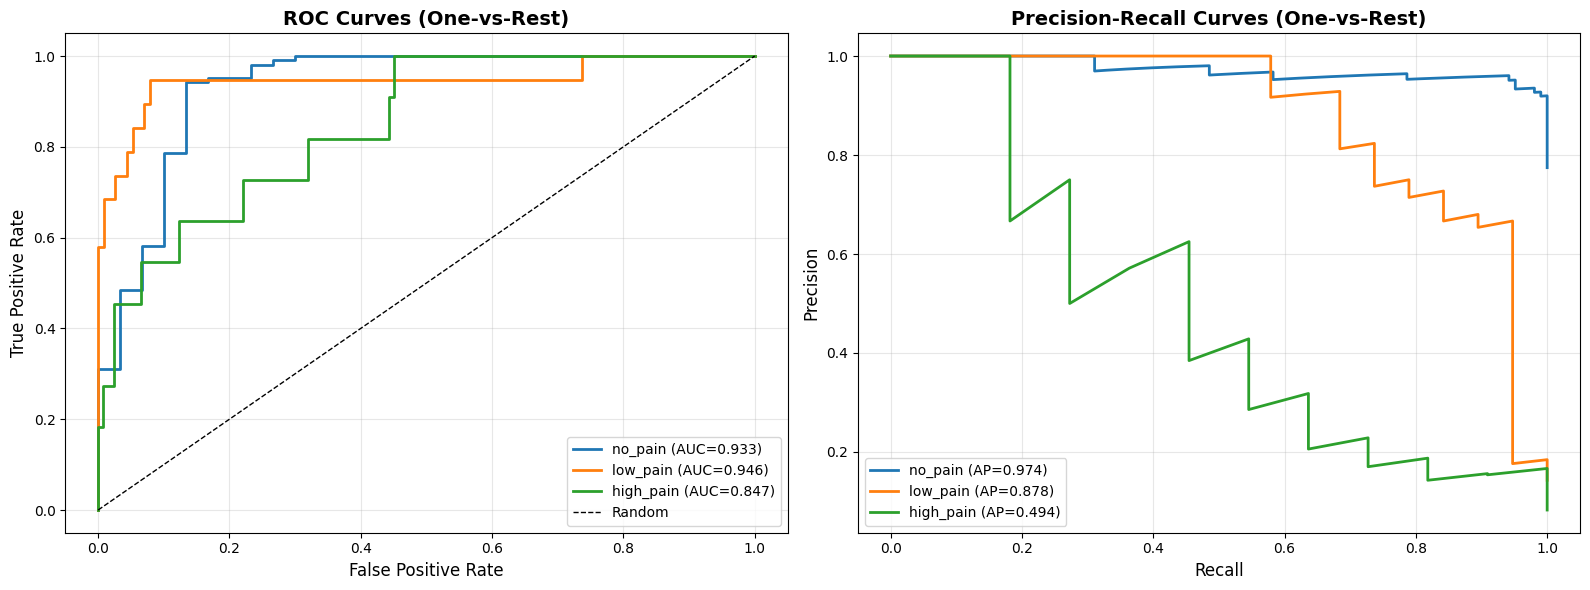

ROC and PR curves saved to ./figures/roc_pr_curves.png


In [99]:
# ROC Curves (One-vs-Rest)
y_val_proba = best_model.predict(X_val, verbose=0)
y_val_binary = to_categorical(y_val, num_classes=num_classes)
label_names = [id_to_label[i] for i in range(num_classes)]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_val_binary[:, i], y_val_proba[:, i])
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, label=f"{label_names[i]} (AUC={roc_auc:.3f})", linewidth=2)

axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curves (One-vs-Rest)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Precision-Recall
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_val_binary[:, i], y_val_proba[:, i])
    avg_precision = average_precision_score(y_val_binary[:, i], y_val_proba[:, i])
    axes[1].plot(recall, precision, label=f"{label_names[i]} (AP={avg_precision:.3f})", linewidth=2)

axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curves (One-vs-Rest)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./figures/roc_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("ROC and PR curves saved to ./figures/roc_pr_curves.png")

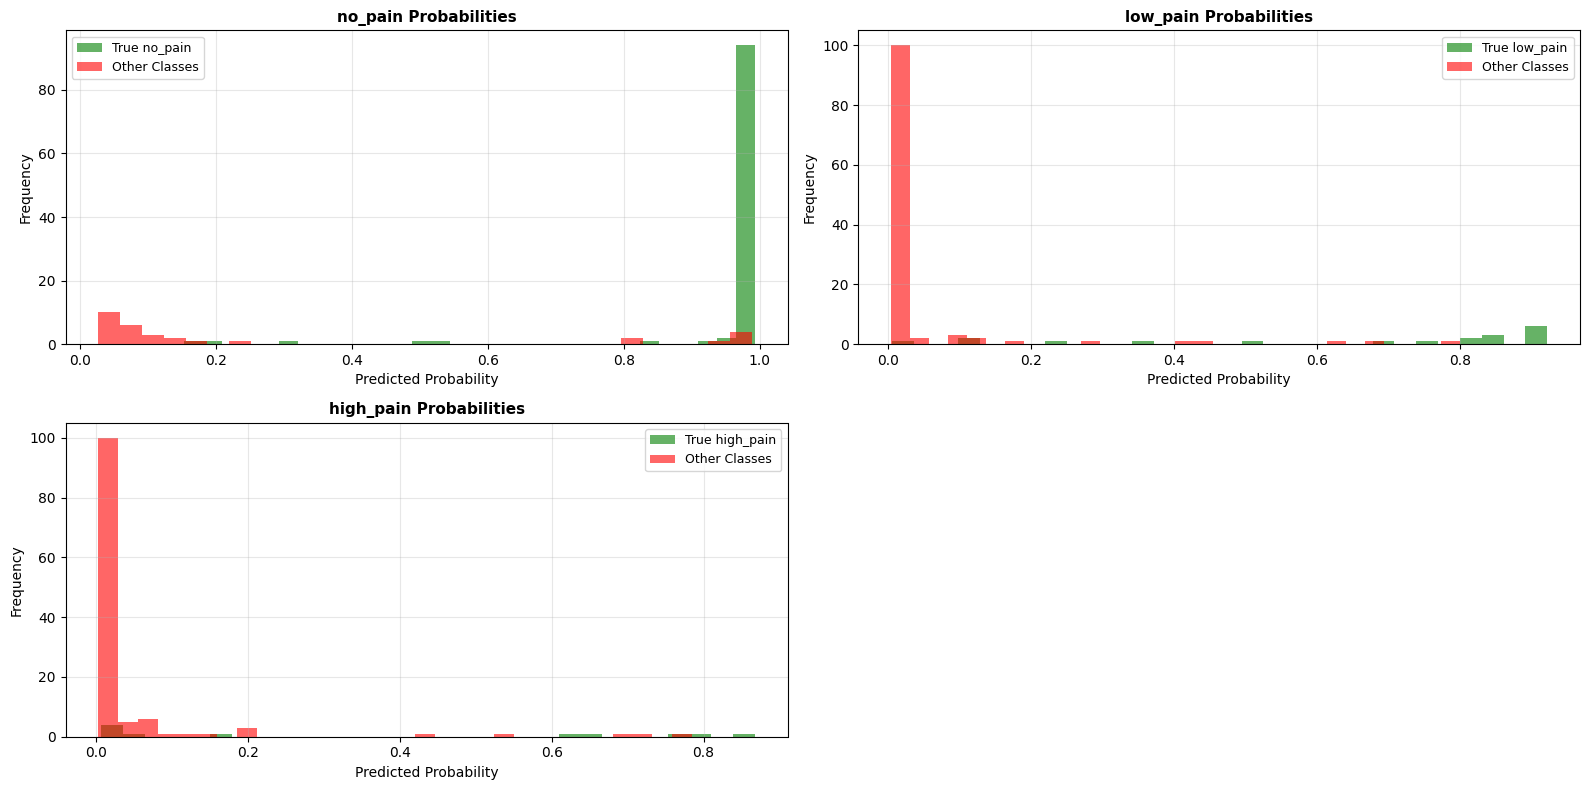

Probability distributions saved to ./figures/probability_distributions.png


In [100]:
# Probability distributions per class
label_names = [id_to_label[i] for i in range(num_classes)]
fig, axes = plt.subplots(2, (num_classes + 1) // 2, figsize=(16, 8))
axes = axes.flatten()

for i in range(num_classes):
    true_class_probs = y_val_proba[y_val == i, i]
    false_class_probs = y_val_proba[y_val != i, i]
    
    axes[i].hist(true_class_probs, bins=30, alpha=0.6, label=f'True {label_names[i]}', color='green')
    axes[i].hist(false_class_probs, bins=30, alpha=0.6, label='Other Classes', color='red')
    axes[i].set_xlabel('Predicted Probability', fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)
    axes[i].set_title(f'{label_names[i]} Probabilities', fontsize=11, fontweight='bold')
    axes[i].legend(fontsize=9)
    axes[i].grid(True, alpha=0.3)

for i in range(num_classes, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('./figures/probability_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
print("Probability distributions saved to ./figures/probability_distributions.png")

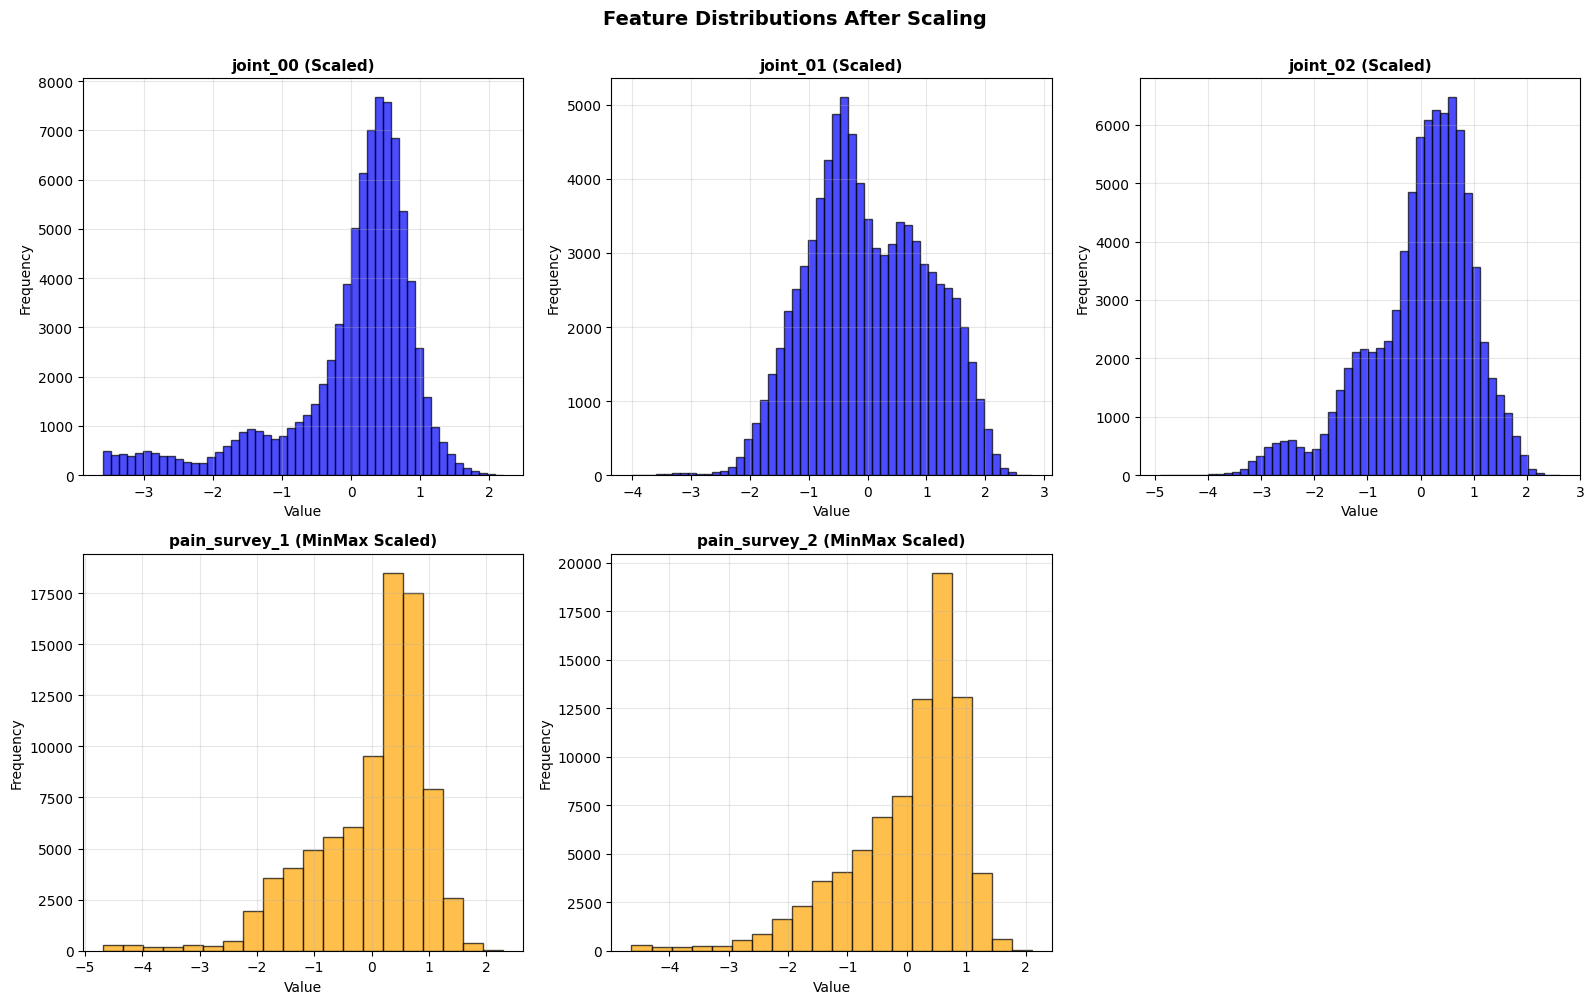

Feature distributions saved to ./figures/feature_distributions.png


In [101]:
# Feature distribution visualization
sample_joint_cols = joint_cols[:3] if len(joint_cols) >= 3 else joint_cols
sample_survey_cols = survey_cols[:2] if len(survey_cols) >= 2 else survey_cols

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

for i, col in enumerate(sample_joint_cols):
    col_idx = all_feature_cols.index(col)
    feature_data = X_train[:, :, col_idx].flatten()
    axes[0, i].hist(feature_data, bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0, i].set_title(f'{col} (Scaled)', fontsize=11, fontweight='bold')
    axes[0, i].set_xlabel('Value', fontsize=10)
    axes[0, i].set_ylabel('Frequency', fontsize=10)
    axes[0, i].grid(True, alpha=0.3)

for i, col in enumerate(sample_survey_cols):
    col_idx = all_feature_cols.index(col)
    feature_data = X_train[:, :, col_idx].flatten()
    axes[1, i].hist(feature_data, bins=20, alpha=0.7, color='orange', edgecolor='black')
    axes[1, i].set_title(f'{col} (MinMax Scaled)', fontsize=11, fontweight='bold')
    axes[1, i].set_xlabel('Value', fontsize=10)
    axes[1, i].set_ylabel('Frequency', fontsize=10)
    axes[1, i].grid(True, alpha=0.3)

for i in range(len(sample_survey_cols), 3):
    axes[1, i].axis('off')

plt.suptitle('Feature Distributions After Scaling', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('./figures/feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
print("Feature distributions saved to ./figures/feature_distributions.png")

## 10. Test Predictions and Submission

In [102]:
# Predict on test set
test_proba = best_model.predict(X_test, verbose=0)
test_pred = test_proba.argmax(axis=1)

print(f"Test predictions shape: {test_pred.shape}")
print(f"Test probabilities shape: {test_proba.shape}")

# Verify test sample indices match submission format
print(f"\nTest sample indices: {len(test_sample_indices)}")
print(f"Sample submission rows: {len(sample_submission)}")

Test predictions shape: (1324,)
Test probabilities shape: (1324, 3)

Test sample indices: 1324
Sample submission rows: 1324


In [103]:
# Create submission file matching sample_submission format
submission_df = sample_submission.copy()

# Map test_sample_indices to predictions
pred_map = dict(zip(test_sample_indices, test_pred))

# Get the column names from sample_submission
id_col = sample_submission.columns[0]  # Usually 'id' or 'sample_index'
label_cols = sample_submission.columns[1:]  # Prediction columns

# Fill predictions with original label strings
for idx, row in submission_df.iterrows():
    sample_id = row[id_col]
    if sample_id in pred_map:
        predicted_class = int(pred_map[sample_id])
        predicted_label = id_to_label[predicted_class]
        submission_df.loc[idx, label_cols] = predicted_label

# Save submission
submission_df.to_csv('submission.csv', index=False)
print("Submission saved to submission.csv")
print(f"Submission shape: {submission_df.shape}")
print("Label mapping used for submission:", id_to_label)
print(f"\nFirst few rows:")
print(submission_df.head())

Submission saved to submission.csv
Submission shape: (1324, 2)
Label mapping used for submission: {0: 'no_pain', 1: 'low_pain', 2: 'high_pain'}

First few rows:
   sample_index    label
0             0  no_pain
1             1  no_pain
2             2  no_pain
3             3  no_pain
4             4  no_pain


In [104]:
# Create submission with probabilities
prob_cols = [f"prob_{id_to_label[i]}" for i in range(num_classes)]
submission_probs_df = pd.DataFrame({
    id_col: test_sample_indices
})

for i, col in enumerate(prob_cols):
    submission_probs_df[col] = test_proba[:, i]

submission_probs_df.to_csv('submission_probs.csv', index=False)
print("Submission with probabilities saved to submission_probs.csv")
print(f"Submission probabilities shape: {submission_probs_df.shape}")
print("Probability column order:", prob_cols)
print(f"\nFirst few rows:")
print(submission_probs_df.head())

Submission with probabilities saved to submission_probs.csv
Submission probabilities shape: (1324, 4)
Probability column order: ['prob_no_pain', 'prob_low_pain', 'prob_high_pain']

First few rows:
   sample_index  prob_no_pain  prob_low_pain  prob_high_pain
0             0      0.983222       0.008079        0.008699
1             1      0.990279       0.005126        0.004596
2             2      0.963909       0.019518        0.016573
3             3      0.981475       0.011213        0.007312
4             4      0.984739       0.008513        0.006748


## Final Summary

In [105]:
print("="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"\nT_target: {T_target}")
print("\nLabel mapping (id -> label):")
for idx in range(num_classes):
    print(f"  {idx}: {id_to_label[idx]}")
print(f"Mapping saved to: {Path('label_mapping.json').resolve()}")

print(f"\nBest Configuration:")
for key, value in best_config.items():
    print(f"  {key}: {value}")
print(f"\nValidation Metrics:")
print(f"  Macro F1: {f1_macro:.4f}")
print(f"  Accuracy: {(y_val_pred == y_val).mean():.4f}")

print(f"\nF1 Scores per Class:")
for i, f1 in enumerate(f1_per_class):
    print(f"  {id_to_label[i]}: {f1:.4f}")

print("\nOutput Files:")
print("  - submission.csv")
print("  - submission_probs.csv")
print("  - best_config.json")
print("  - label_mapping.json")
print("  - ./figures/training_curves.png")
print("  - ./figures/confusion_matrix.png")
print("  - ./figures/roc_pr_curves.png")
print("  - ./figures/probability_distributions.png")
print("  - ./figures/feature_distributions.png")
print("="*60)

FINAL SUMMARY

T_target: 160

Label mapping (id -> label):
  0: no_pain
  1: low_pain
  2: high_pain
Mapping saved to: C:\Users\filip\Documents\GitHub\challenge_an2dl\label_mapping.json

Best Configuration:
  hidden_size: 128
  num_layers: 2
  dropout: 0.2
  lr: 0.0007

Validation Metrics:
  Macro F1: 0.7434
  Accuracy: 0.8947

F1 Scores per Class:
  no_pain: 0.9524
  low_pain: 0.7778
  high_pain: 0.5000

Output Files:
  - submission.csv
  - submission_probs.csv
  - best_config.json
  - label_mapping.json
  - ./figures/training_curves.png
  - ./figures/confusion_matrix.png
  - ./figures/roc_pr_curves.png
  - ./figures/probability_distributions.png
  - ./figures/feature_distributions.png
